In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import open3d as o3d
from datetime import datetime

from utils import *
from manus_utils import ManusData

import sys
manopth_dir = 'C:/Users/lucas/Desktop/UPC/MIT/manopth/'
sys.path.insert(1, manopth_dir)

from manus.utils import Pressure

In [3]:
data_dir = "C:/Users/lucas/Desktop/UPC/MIT/tactile2object/real_data/data"
recording = "20210803/r4/"
recording_dir = os.path.join(data_dir, recording)

for name in os.listdir(recording_dir):
    name_pth = os.path.join(recording_dir, name)
    
    if os.path.isdir(name_pth):
        print("cameras_dir:", name)
        cameras_dir = name_pth
        
    elif ".hdf5" in name:
        print("pressure_file:", name)
        perssure_pth = name_pth
        
    elif ".xlsx" in name:
        print("manus_file:", name)
        manus_pth = name_pth
        
#cameras_dir = os.path.join(recording_dir, "20210722_152500")
#perssure_pth = os.path.join(recording_dir, ".hdf5")
#manus_pth = os.path.join(recording_dir, ".fbx")

pressure_file: 08032021_4.hdf5
manus_file: 08032021_4.xlsx
cameras_dir: 20210803_161941


# Load data

### Camera data

In [4]:
cameras = ["020122061233", "821312060044", "020122061651", "821312062243"]

intrinsics = Intrinsics(cameras_dir, use_txt=False)
extrinsics = Extrinsics(cameras_dir)
rgbds = RGBD(cameras_dir)
stitched_pcd = Stitching_pcds(intrinsics, extrinsics, rgbds, cameras)
apriltags = AprilTags(cameras_dir, intrinsics, extrinsics, cameras=cameras)
stitched_pcd = Stitching_pcds(intrinsics, extrinsics, rgbds, cameras)

### Pressure data

In [5]:
pressure = Pressure(perssure_pth, lim_low=3, lim_high=50)

### Manus data

Takes around two minutes to load the manus data and compute the MANO joints and verts

In [6]:
%%capture

manus = ManusData(manus_pth, manopth_dir)

# Synchronize

#### Get timestamps

In [7]:
# Camera timestamps
ts_camera = get_camera_timestamps(cameras_dir)

# Pressure timestamps
ts_pressure = pressure.ts_touch

# MANUS timestamp
ts_manus = manus.get_ts()

In [8]:
datetime.fromtimestamp(ts_pressure[-1]) - datetime.fromtimestamp(ts_pressure[0])

datetime.timedelta(seconds=73, microseconds=127581)

In [9]:
datetime.fromtimestamp(ts_manus[-1]) - datetime.fromtimestamp(ts_manus[0])

datetime.timedelta(seconds=67, microseconds=566667)

#### Find pressure camera offset


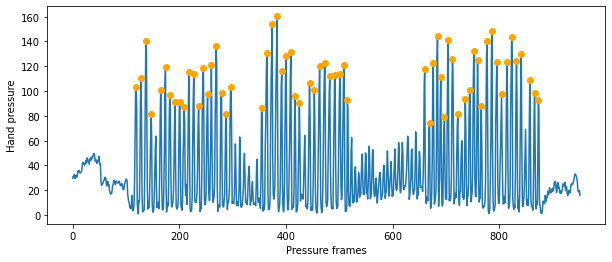

In [22]:
pressure.plot_peaks(height=70, distance=5)

In [23]:
# Index of first pressure peak 
idx_first_p = pressure.get_peaks(height=70, distance=5)[0]
# Timestamp of first pressure peak
ts_first_p = pressure.ts_touch[idx_first_p]

# Frame of first pressure in camera
frame_first_c = 137
# Timestamp of first pressure in camera
ts_first_c = ts_camera[frame_first_c]

# Offset between pressure and camera
pc_offset = ts_first_p - ts_first_c

#### Find manus camera offset


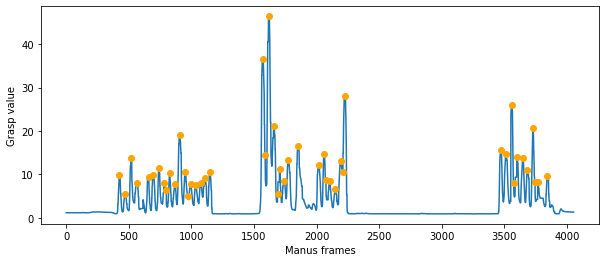

In [24]:
manus.plot_grasps(height=5)

In [25]:
manus.get_grasps(height=5)

array([ 425,  470,  516,  563,  658,  695,  740,  783,  799,  826,  868,
        906,  951,  971,  993, 1033, 1074, 1105, 1147, 1569, 1588, 1618,
       1659, 1688, 1705, 1740, 1775, 1850, 2017, 2060, 2075, 2105, 2150,
       2192, 2209, 2225, 3475, 3513, 3558, 3575, 3601, 3650, 3685, 3730,
       3745, 3768, 3844], dtype=int64)

In [26]:
# Index of first manus grasp peak 
idx_first_m = 1569
# Timestamp of first manus grasp peak
ts_first_m = ts_manus[idx_first_m]

# Frame of first grasp in camera
frame_first_c = 700
# Timestamp of first pressure in camera
ts_first_c = ts_camera[frame_first_c]

# Offset between pressure and camera
mc_offset = ts_first_m - ts_first_c

In [27]:
datetime.fromtimestamp(ts_first_m) - datetime.fromtimestamp(ts_first_c) 

datetime.timedelta(seconds=4, microseconds=749414)

#### Synchronize pressure + camera + manus

In [28]:
synchronize = Synchronizer(ts_p=ts_pressure, ts_c=ts_camera, ts_m=ts_manus, pc_offset=pc_offset, mc_offset=mc_offset)

# Merge camera + pressure + manus

#### Estimate object position

In [ ]:
%%capture

pcd = stitched_pcd["000000"]

obj_name = "005_tomato_soup_can"
obj_name = "003_cracker_box"
obj_name = "006_mustard_bottle"
obj_name = "036_wood_block"

obj_pth = f"C:/Users/lucas/Desktop/UPC/MIT/tactile2object/estimate_object_pose/ycb_converted/{obj_name}.ply"

# Useful when running the cell multiple times
try:
    obj_mesh_t # obj_mesh_t exist in the current namespace
except NameError:
    transformation, obj_mesh_t = find_object_transformation(pcd, obj_pth)

In [ ]:
#o3d.visualization.draw_geometries([pcd, obj_mesh_t])

#### Plot mesh_hand + object + AprilTag

In [ ]:
frame_c = 652
frame_m = synchronize.camera_to_manus(frame_c)
frame_c = str(frame_c).zfill(6)

# pcd = stitched_pcd[frame_c]
corners_w = apriltags.corners_w(idx=frame_c)

rectangle = get_rectangle_from_corners(corners_w)
mesh_hand = manus.from_corners(frame_m, corners_w)

o3d.visualization.draw_geometries([mesh_hand, obj_mesh_t, rectangle, stitched_pcd[frame_c]])

# Save tactile img

In [29]:
tactile_dir = os.path.join(apriltags.cameras_dir, "imgs", "pressure_img")

if not os.path.exists(tactile_dir):
    os.makedirs(tactile_dir)

for frame_c in range(len(ts_camera)):
    frame_p = synchronize.camera_to_pressure(frame_c)
    
    fig = pressure.get_figure(frame_p, show=False)
    img_pth = os.path.join(tactile_dir, f"img_{frame_c}")
    fig.savefig(img_pth)

# Save MANUS

#### Manus with object

In [ ]:
out_dir = os.path.join(apriltags.cameras_dir, "imgs", "manus_img")

if not os.path.exists(out_dir):
    os.makedirs(out_dir)

corners_w = apriltags.corners_w(idx='000675')

for frame_m in range(0, len(manus)):
    rectangle = get_rectangle_from_corners(corners_w)
    mesh_hand = manus.from_corners(frame_m, corners_w)
    
    img_pth = os.path.join(out_dir, f"img_{frame_m}.png")
    save_draw_geometries([obj_mesh_t, mesh_hand], img_pth)

#### Manus +  object + pcd

In [ ]:
out_dir = os.path.join(apriltags.cameras_dir, "imgs", "manus_pcd_img_20")

if not os.path.exists(out_dir):
    os.makedirs(out_dir)
    
for frame_c in range(0, len(ts_camera)):
    frame_m = synchronize.camera_to_manus(frame_c)
    
    frame_c = str(frame_c).zfill(6)
    pcd = stitched_pcd[frame_c]
    
    corners_w = apriltags.corners_w(idx=frame_c)
    
    if corners_w is None:
        vis = obj_mesh_t

    else:
        rectangle = get_rectangle_from_corners(corners_w)
        mesh_hand = manus.from_corners(frame_m, corners_w)
        
        vis = [obj_mesh_t, mesh_hand, rectangle]
        
    img_pth = os.path.join(out_dir, f"img_{frame_c}.png")
    save_draw_geometries(vis, img_pth)